# Ejemplo de Identificación de Sistemas
*Ignacio Díaz Blanco, 2023. Universidad de Oviedo.*

En este ejemplo se muestra el proceso de identificación sobre datos simulados de un motor DC. Se obtiene un modelo sencillo del subsistema mecánico que relaciona la corriente de inducido $I_i$ con la velocidad de giro del motor $\omega_m$. El modelo resultante contiene información sobre la constante de par del motor $K_p$, así como sobre el momento de inercia $J$ y la fricción al giro $B$ del motor.

Los datos se tomaron de una simulación en Simulink:

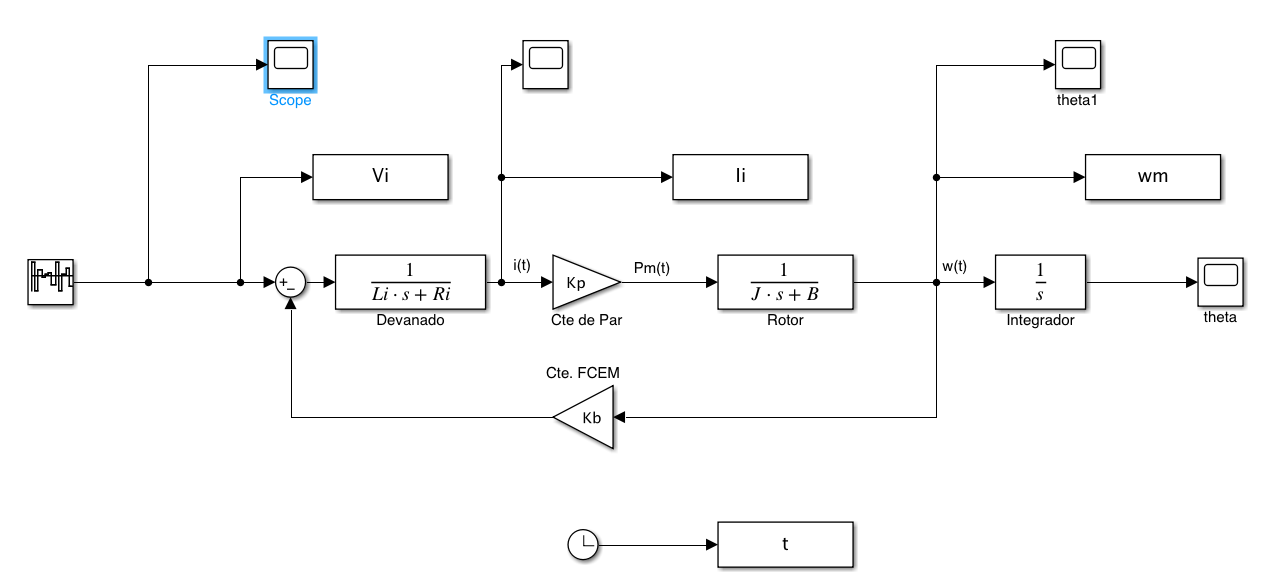


El siguiente código invoca a la simulación para recoger los datos de los sensores y almacenarlos en forma de matriz en un archivo de texto, tipo `CSV`
```python
% DATOS DEL MOTOR DE CONTINUA:
% (SON DATOS REALES DE UN MOTOR DEL LABORATORIO DE MANIOBRAS DE PERITOS)
Kp = 0.55;
Ri = 1.1648;
Li = 0.0068;
Kb = 0.82;
B  = 0.00776;
J  = 0.0271;

sim("motorcc.mdl")

writematrix([t,Vi,wm,Ii],'motor_dc.csv')
```

---

In [1]:
from scipy.signal import lfilter
import numpy as np
import matplotlib.pyplot as plt

### Importamos los datos de simulación del motor


In [2]:
import pandas as pd

df = pd.read_csv('../../datos/motor_dc.csv')
df.columns = ['t','Vi','wm','Ii']
df

,t,Vi,wm,Ii
0,0.0002,1.0,0.000059,0.028913
1,0.0004,1.0,0.000233,0.056850
2,0.0006,1.0,0.000519,0.083840
3,0.0008,1.0,0.000913,0.109913
4,0.0010,1.0,0.001410,0.135098
...,...,...,...,...
49995,9.9992,1.0,0.039922,0.075438
49996,9.9994,1.0,0.040277,0.100861
49997,9.9996,1.0,0.040735,0.125417
49998,9.9998,1.0,0.041290,0.149135


### Dibujamos los datos
Generaremos ahora un conjunto de datos de test. Someteremos nuestro sistema $G(z)$ a otra señal de entrada diferente (en este caso, cuadrada), que no hemos utilizado en la estimación del modelo.

In [3]:
# Tamaño del conjunto de test
Q = df.values.shape[0]

t  = df.values[:,0]
Vi = df.values[:,1]
wm  = df.values[:,2]
Ii  = df.values[:,3]
dwm = np.gradient(wm,t)
dIi = np.gradient(Ii,t)

print(dwm[:10])


[0.87187569 1.15050603 1.69829727 2.22744261 2.73851914 3.2320862
 3.70868602 4.16884419 4.61307016 4.74678628]


<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/var/folders/kl/1v2yl4xd5fj999gkvkbg3j0w0000gn/T/ipykernel_91898/1439464518.py:10: SyntaxWarning: invalid escape sequence '\o'
  plt.legend(['velocidad de giro $\omega_m$'], loc='upper right')


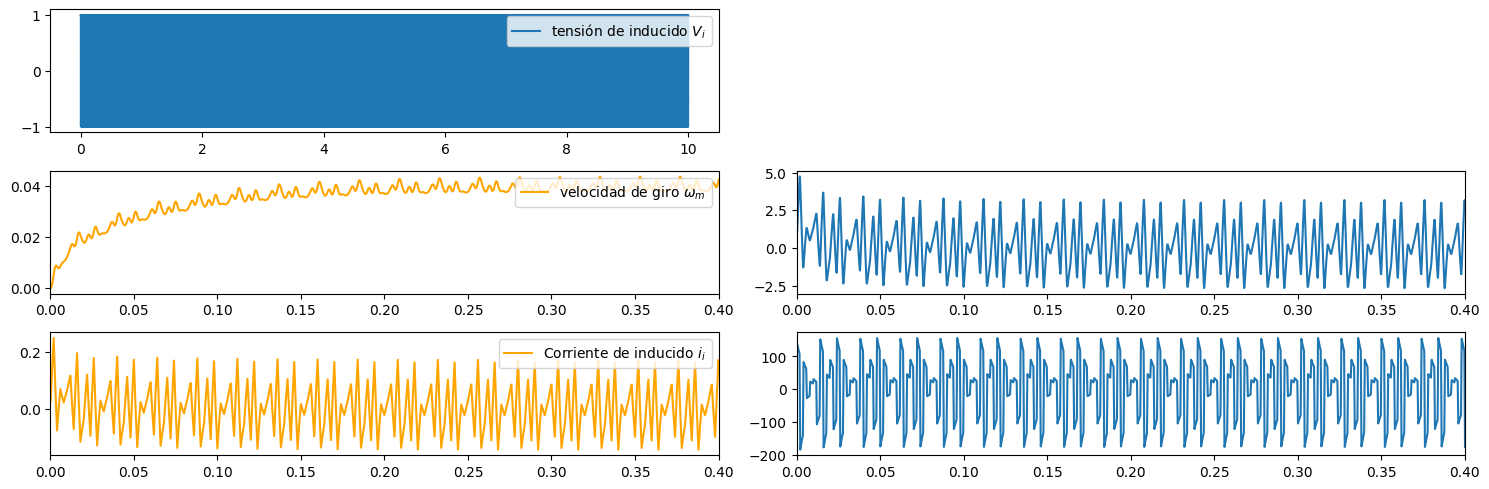

In [4]:


# Mostramos la respuesta
plt.figure(1,figsize=(15,5))
plt.subplot(3,2,1)
plt.plot(t,Vi)
plt.legend(['tensión de inducido $V_i$'],loc='upper right')


plt.subplot(3,2,3)
plt.plot(t,wm, color='orange')
plt.legend(['velocidad de giro $\omega_m$'], loc='upper right')
plt.axis(xmin=0,xmax=0.4)

plt.subplot(3,2,4)
plt.plot(t,dwm)
plt.axis(xmin=0,xmax=0.4)


plt.subplot(3,2,5)
plt.plot(t,Ii, color='orange')
plt.legend(['Corriente de inducido $i_i$'], loc='upper right')
plt.axis(xmin=0,xmax=0.4)

plt.subplot(3,2,6)
plt.plot(t,dIi)
plt.axis(xmin=0,xmax=0.4)



plt.tight_layout()

#### Estimación del subsistema mecánico
$$
G(s) = \frac{K_p}{Js + B}
$$

En términos de ecuación diferencial es
$$
K_p I_i = J \dot \omega_m + B \omega_m 
$$

Reordenando términos, tenemos

$$
I_i = \frac{J}{K_p}  \dot \omega_m + \frac{B}{K_p} \omega_m
$$

que podemos verlo como

$$
y = \theta_1 x_1 + \theta_2 x_2
$$

In [5]:
# creamos la matriz X con la derivada de la velocidad y la velocidad
# idem    la matriz y con la corriente de inducido
X = np.column_stack((np.gradient(wm,t),wm))
y = np.column_stack((Ii)).ravel()
print(X.shape)
print(y.shape)

# método 1: ridge regression (regulador Tikhonov)
print(np.linalg.inv(X.T@X + 0.00001*np.eye(2))@X.T@y)

# método 2: pseudoinversa
print(np.linalg.pinv(X)@y)

# método 3: ridge regression con scikit-learn
from sklearn.linear_model import Ridge
clf = Ridge(alpha=.00001, fit_intercept=True)
clf.fit(X,y)
print(clf.coef_)

(50000, 2)
(50000,)
[0.05020054 0.01409647]
[0.05020054 0.01409647]
[0.05020159 0.04058015]


In [6]:
# comprobamos con los parámetros reales
Kp = 0.55; Ri = 1.1648; Li = 0.0068; Kb = 0.82; B  = 0.00776; J  = 0.0271; 

print(J/Kp, B/Kp)

print('bastante aproximado !')

0.04927272727272727 0.014109090909090908
bastante aproximado !


### Representación de los resultados (real vs. estimado)

(np.float64(0.0),
 np.float64(0.4),
 np.float64(-0.1611580794750079),
 np.float64(0.26813765082706587))

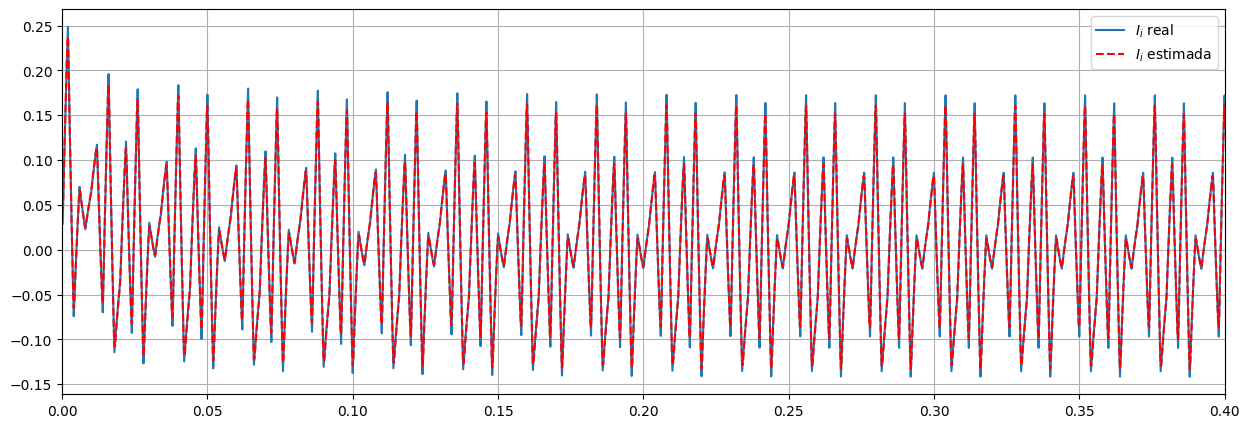

In [7]:
Ii_estimada = clf.predict(X)

plt.figure(figsize=(15,5))
plt.plot(t,Ii)
plt.legend(['real'])

plt.plot(t, Ii_estimada,'r--')
plt.legend(['$I_i$ real','$I_i$ estimada'])
plt.grid(visible=True)
plt.axis(xmin=0,xmax=0.4)